                                        USING PYTHON FOR RESEARCH: Final Project

   This work corresponds to the Final Project of the course Using Python for Research, given by HarvardX on the online plataform EdX. In this project, the row data provided by accelerometers will be analized using different skills learned all over the course, trying to predict the type of physical activity given by the patterns of acceleration in three axes x, y and z.
   
   In this case, the physical activity is classified by four labels, beeing 1 for 'Standing', 2 for 'Walking', 3 for 'Stairs Down' and 4 for 'Stairs Up'. This labels classify each activity taking into account ten measures of the 3-axis accelerations.
   
   The data provided by the course consists on four tables divided in two: the training data contain the data classified, and it's used to train the algorithm; and the test data, that contains the acceleration information, but not the classifications, and will be used to do the predictions. For each data, we have one table with all the acceleration measurenments, and one table with the classification of the physical activity, done taking into account ten acceleration measurenments.
   
   The final objective of the project is to predict the physical activity from raw accelerometer data as accurately as possible, using known data to train the predict algorithm.
   
   The first thought to approach the problem was to look what can be different in each spatial patron of physical activity, and the first answer was to think about the differences between the acceleration in each axis. For example, the activities 'Stairs Down' and 'Stairs Up' will have characteristical differences in the y axis, but the activities 'Standing' and 'Walking' will have less predominance in that axis. Because of that, the first approach was try to take into account the accelerations in each axis for each timestamp. This was the plot obtained:

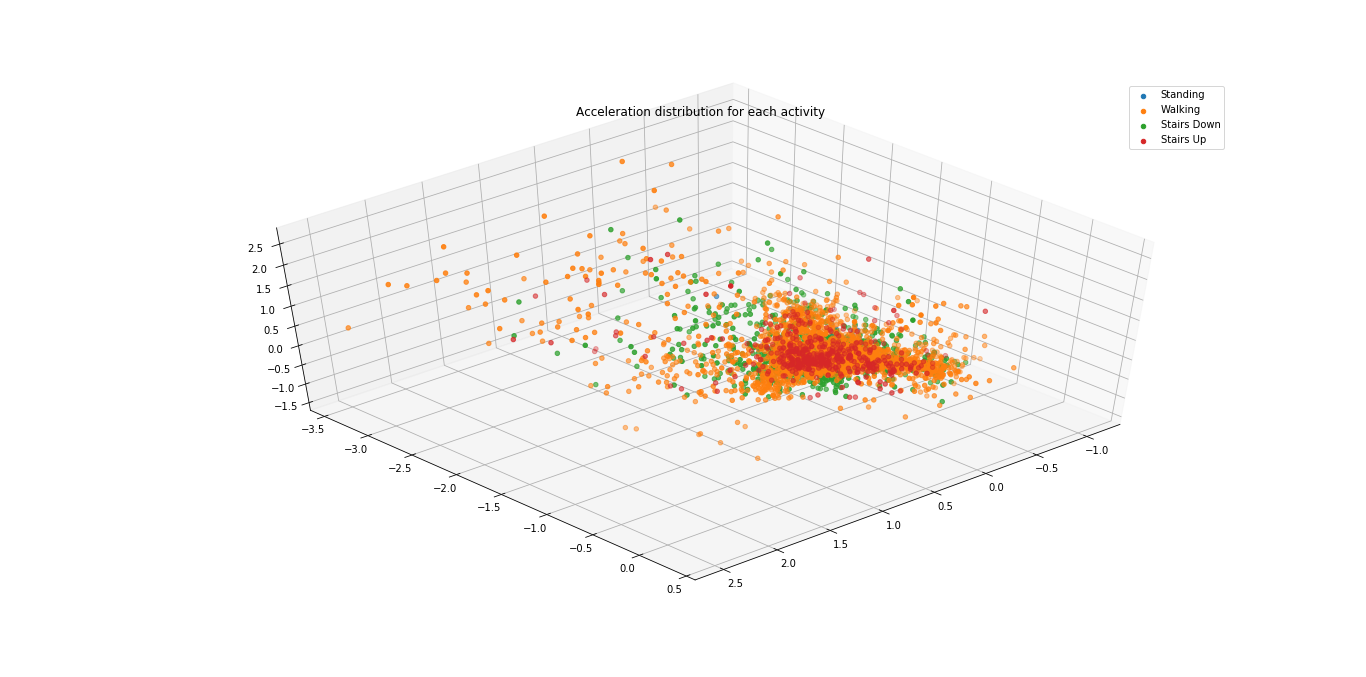

In [1]:
from IPython.display import Image
Image('accelerations_fig.png', width=920)

   In this case, the diferences between each physical activity is not clear. But when we plot the mean of each label we obtain the next plot:

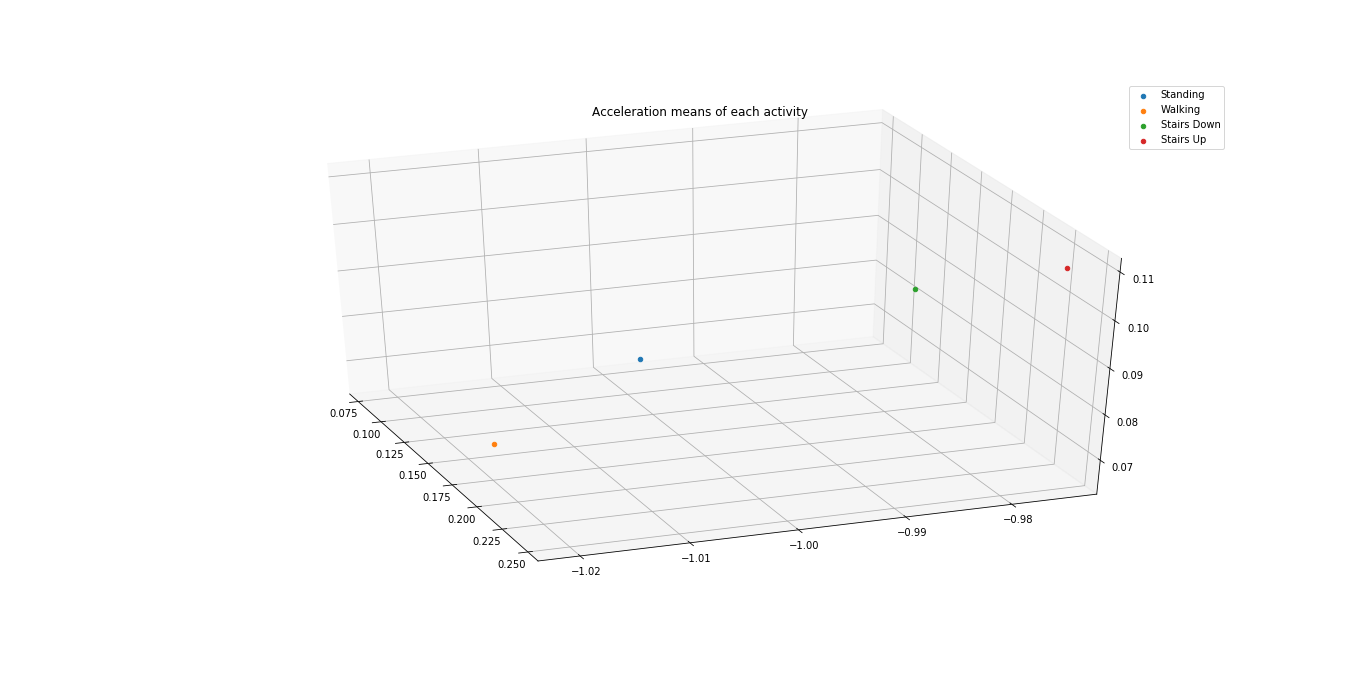

In [2]:
Image('accelerations_means.png', width=920)

   This difference between each physical activity is more clear, and will be used to classify the difference between each one.
   
   The aproach chosen for this first attempt to solve the problem is to take ten measures of acceleration, calculate the mean in each axis, and find the nearest point in that plot. This will provide the classification of the given training data.

                                                        METHODS

   This part will explain the process used to solve the problem. The first thing to do is to take the start time of the code run. At the end of the code we are going to take the end time to be able to inform the time that the code takes to run.

In [3]:
from time import process_time
start_time = process_time()

   To start, is necessary to open the files provided by the course. To do that and manipulate it, is necessary to import the Pandas library:

In [4]:
import pandas as pd

test_labels = pd.read_csv('test_labels.csv', index_col=0)
test_time_series = pd.read_csv('test_time_series.csv', index_col=0)
train_labels = pd.read_csv('train_labels.csv', index_col=0)
train_time_series = pd.read_csv('train_time_series.csv', index_col=0)

   A useful thing to do with the tables is to reset the indexes given, to make it better manipulable:

In [5]:
train_labels = train_labels.reset_index()
train_time_series = train_time_series.reset_index()
test_labels = test_labels.reset_index()
test_time_series= test_time_series.reset_index()

   The train_time_series table only have the acceleration information. To take the complete data into account to do the classification and train the algorithm is necessary to complete this table with the corresponding labels, provided by the train_labels table.

   The idea is to take one of the labels in the table train_labels and iterate over train_time_series table, completing the empty labels until the timestamp for both matches. In that moment, the iteration in the train_time_series table breaks, and returns to the next row in train_labels table.

In [6]:
labels = []    #We are going to save the labels in this list
r = 0          #and the value of r will take the given row

for i in range(len(train_labels.label)):
    
    lab = train_labels.label[i]    #We start taking label of the row
    
    for j in range(r, len(train_time_series.timestamp)):    #Now we loop over the empty table
        if train_time_series['timestamp'][j] != train_labels['timestamp'][i]:    #and iterate until timestamps match
            labels.append(lab)
        else:                     #If timestamps matches
            labels.append(lab)    #we append the last label,
            r = j+1              #we take the next row as reference to start the next iteration,
            break                 #and we break the inner loop
            
#When we get the list, we add it to the table as a new column

train_time_series['label'] = labels

   Now we are going to group the data by labels, take the mean of each axis acceleration, and store that information as a 3-axis point for each label.

In [7]:
import numpy as np

grouped_data = train_time_series.groupby(by='label')

x1 = np.array([i for i in grouped_data.get_group(1)['x']])
y1 = np.array([i for i in grouped_data.get_group(1)['y']])
z1 = np.array([i for i in grouped_data.get_group(1)['z']])

x2 = np.array([i for i in grouped_data.get_group(2)['x']])
y2 = np.array([i for i in grouped_data.get_group(2)['y']])
z2 = np.array([i for i in grouped_data.get_group(2)['z']])

x3 = np.array([i for i in grouped_data.get_group(3)['x']])
y3 = np.array([i for i in grouped_data.get_group(3)['y']])
z3 = np.array([i for i in grouped_data.get_group(3)['z']])

x4 = np.array([i for i in grouped_data.get_group(4)['x']])
y4 = np.array([i for i in grouped_data.get_group(4)['y']])
z4 = np.array([i for i in grouped_data.get_group(4)['z']])

means_1 = [x1.mean(), y1.mean(), z1.mean()]
means_2 = [x2.mean(), y2.mean(), z2.mean()]
means_3 = [x3.mean(), y3.mean(), z3.mean()]
means_4 = [x4.mean(), y4.mean(), z4.mean()]

   Now we have the needed means for each label group ready to predict the new data. The idea in the prediction part is to use a window of ten measurenments in the unknown data table test_time_series. For each window we will asign the predicted label taking the closer point in the 3D space of the means descripted before, and assign this value to all of the observations taken in the window.

   The result of this will be the collection of ten predictions for each observation, and that could be useful to reduce wrong predictions and detect changes of physical activity in the dataset. For each list of predictions, the mode will be taken, and that value will be the label assigned for the observation.

In [8]:
#First we are going to define a function that takes one point, and determines the distance to the others taken by reference

def closer_label(x, y, z):
    """
    This function takes the 3-axis position of a point and calculates the distance to the mean points of each label.
    Finally, it returns the closer point.
    """
    dist = {}    #In this dictionary we will append the label and the correspond distance
    
    dist[1] = float(np.sqrt((xs-means_1[0])**2+(ys-means_1[1])**2+(zs-means_1[2])**2))
    dist[2] = float(np.sqrt((xs-means_2[0])**2+(ys-means_2[1])**2+(zs-means_2[2])**2))   #Here we obtain the distance between each point
    dist[3] = float(np.sqrt((xs-means_3[0])**2+(ys-means_3[1])**2+(zs-means_3[2])**2))   #and the references points for the window
    dist[4] = float(np.sqrt((xs-means_4[0])**2+(ys-means_4[1])**2+(zs-means_4[2])**2))

    for k,v in dist.items():
        if min(dist.values()) == v:    #We take the lower value of distance
            label = k                  #and return the corresponding label
            
    return label

In [9]:
#Here we are going to take the test data and generate the estimates of the labels for each observation

label_estimate = pd.DataFrame(columns= ['row', 'label'])    #We'll store the estimates in a DataFrame
row = 10    #This value of row will be useful to start the first window

for i in range(10, len(test_time_series.x)):
    
    xs = np.array(test_time_series['x'][i-10:i]).mean()
    ys = np.array(test_time_series['y'][i-10:i]).mean()   #Here we take the mean of each axis for the window
    zs = np.array(test_time_series['z'][i-10:i]).mean()
    
    label = closer_label(xs, ys, zs)    #We use the function to determine the closer label
    
    for n in reversed(range(11)):                       #Now we take the ten values used in the window
        if row-n in label_estimate['row']:        #if the row have already been appended, we concatenate the new label to the others
            label_estimate['label'].loc[row-n] += [label]
        else:                                     #if it's the first value to append, we add the label to the row as a list
            label_estimate.loc[row-n] = row-n, [label]

    row +=1    #And finally, we pass one row in the window


In [10]:
#The next step is to take the mean of the list of each row of the label_estimate table, and store it as the final label predicted

from statistics import mode

predictions = []

for i in range(len(label_estimate.label)):
    try:
        predictions.append(mode(label_estimate.label[i]))    #We append the mode of the list of predictions
    except:
        predictions.append(predictions[i-1])                 #But in case that obtain more than one mode value, we will append the last label,
                                                             #corresponding with the last window observation
#Now we have to add this data to the test_time_series table

test_time_series['predictions'] = predictions

   Now we have all the predictions for the observations taken by the new accelerometer data. The next step is take those rows needed to complete the final table, test_labels.

In [11]:
#First we extract the predictions for each row that is in both tables
label = [i for i in test_time_series[test_time_series['timestamp'].isin(test_labels['timestamp'])].predictions]

#And then, we use this list to append it to the predictions of the test_labels table
test_labels['label'] = label

   The final step is to save the new test_labels table as a .csv file, and to take the end tine of the run code, and to inform the total time running.

In [12]:
test_labels.to_csv('test_labels.csv', index=False)

end_time = process_time()

print('Time of running: ', end_time-start_time, 's')

Time of running:  15.765625 s


                                                            RESULTS

   The first thing to observe is the accuracy of the method. For this we have to extract all the labels predicted by the algorithm and calculate the accuracy by submitting that as the answer of the problem.

In [13]:
print('The labels predicted are: ', [i for i in test_labels.label])

The labels predicted are:  [4, 4, 4, 4, 2, 2, 4, 4, 4, 3, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 4, 4, 4, 3, 4, 4, 2, 1, 4, 3, 4, 4, 4, 4, 2, 2, 2, 4, 4, 4, 1, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 2, 1, 2, 4, 4, 4, 2, 2, 2, 4, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 1, 2, 1, 2, 4, 2, 1]


   When I submit the answer, the accuracy informed is 48.0%. It's true that this number can seems low, but if we take as reference an algorithm that assigns the labels by random, we obtain 25.0% of accuracy. Compairing these two numbers we can observe that the algorithm used in this project could classificate the physical activities with the double of accuracy than a random algorithm. Nevertheless, it's also clear that the method has to been improved or the approach taken has to change to reach higher accuracy.

   If we observe the labels predicted, we can see that there are some labels that appears to be wrong, because there are between other sucession of labels. Maybe, in this parts of the data we have a change in the physical activity, from one to another, and we can think that this approach of the code is weak to determine the classification when the physical activity is changing. On the other hand, the low number of the label number 3 leads us to think that there can be a problem to distinguish this physical activity to the closer point: the label number 4.


   Finally, the other result to evaluate is the run time. For this approach, we obtain approximately 16 seconds, and I think that this time is fast and practice, considering the data and all the operations to do between the four tables.

                                                        CONCLUSIONS
   In this Final Project we was able to predict the classification of physical activity provided by a 3-axis accelerometer data with an accuracy of 48.0%. Compairing this value we can concluded that the algorithm of this project is twice times better than an random-choice algorithm. Nevertheless, the value leads us to think that some parts of the algorithm has to been modified, or the approach has to change, to obtain higher results.

   Thinking about the time of the code runs, the results of approximately 16 seconds seems to indicate that the code is simple and practice to use, taking into account all the considerations of accuracy mentioned above.